# **Real Estate Predictive Modeling & Clustering Analysis Notebook**

Client: Real Estate Company

Author: ZBIR Oussama

Date: 17/02/2025

This notebook covers two primary analysis tasks:
   1. Regression Modeling for predicting 'saleprice'
   2. Property Portfolio Clustering Analysis for targeted marketing and operational efficiency.

Note: All functionalities and details from the original code have been preserved. The structure has been reorganized for improved readability, maintainability, and adherence to best practices.

# 1. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn libraries for preprocessing, modeling, evaluation, and pipelines
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from lightgbm import LGBMRegressor


import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# 2. Data Exploration & Cleaning

## 2.1 Load Dataset

In [ ]:
# Loading the dataset from an Excel file.
data_path = "/content/data_real_estate.xlsx"
df = pd.read_excel(data_path, sheet_name=0)
print("Data loaded successfully!\n")

Data loaded successfully!



In [ ]:
# Quick overview of the DataFrame
print("DataFrame Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1460 non-null   int64  
 1   sub_ms_class      1460 non-null   int64  
 2   zoning_ms         1460 non-null   object 
 3   frontge_lot       1201 non-null   float64
 4   area_lot          1460 non-null   int64  
 5   streetname        1460 non-null   object 
 6   alleyname         91 non-null     object 
 7   shape_lot         1460 non-null   object 
 8   contour_land      1460 non-null   object 
 9   util              1460 non-null   object 
 10  configlot         1460 non-null   object 
 11  slopeland         1460 non-null   object 
 12  neighborhood      1460 non-null   object 
 13  c1                1460 non-null   object 
 14  c2                1460 non-null   object 
 15  type_building     1460 non-null   object 
 16  style_house       1460 non

## 2.2 Missing Data Analysis

In [ ]:
# Checking for missing values in each column
missing_values = df.isnull().sum()
missing_cols = missing_values[missing_values > 0]
print("\nColumns with Missing Data and Their Counts:")
print(missing_cols)


Columns with Missing Data and Their Counts:
frontge_lot      259
alleyname       1369
masvnrtype       872
masvnrarea         8
bsmtqual          37
bsmtcond          37
bsmtexposure      38
bsmtfintype1      37
bsmtfintype2      38
electrical         1
fireplacequ      690
garagetype        81
garageyrblt       81
garagefinish      81
garagequal        81
garagecond        81
poolqc          1453
fence           1179
miscfeature     1406
dtype: int64


## 3. Data Visualization

In [ ]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Separating numeric and categorical columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

## 3.1 Histograms for Numeric Columns

In [ ]:
relevant_numeric_cols = [
    "area_lot",       # Total lot size
    "year_constructed",
    "year_remod",
    "grlivarea",      # Above grade (ground) living area
    "totalbsmtsf",    # Total basement area
    "garagearea",
    "saleprice"       # Target variable for regression
]


In [ ]:
#Creating Dictionaries for Descriptive Titles
numeric_titles = {
    "area_lot": "Lot Size",
    "year_constructed": "Construction Year",
    "year_remod": "Remodel Year",
    "grlivarea": "Above Grade Living Area",
    "totalbsmtsf": "Total Basement Area",
    "garagearea": "Garage Area",
    "saleprice": "Sale Price"
}

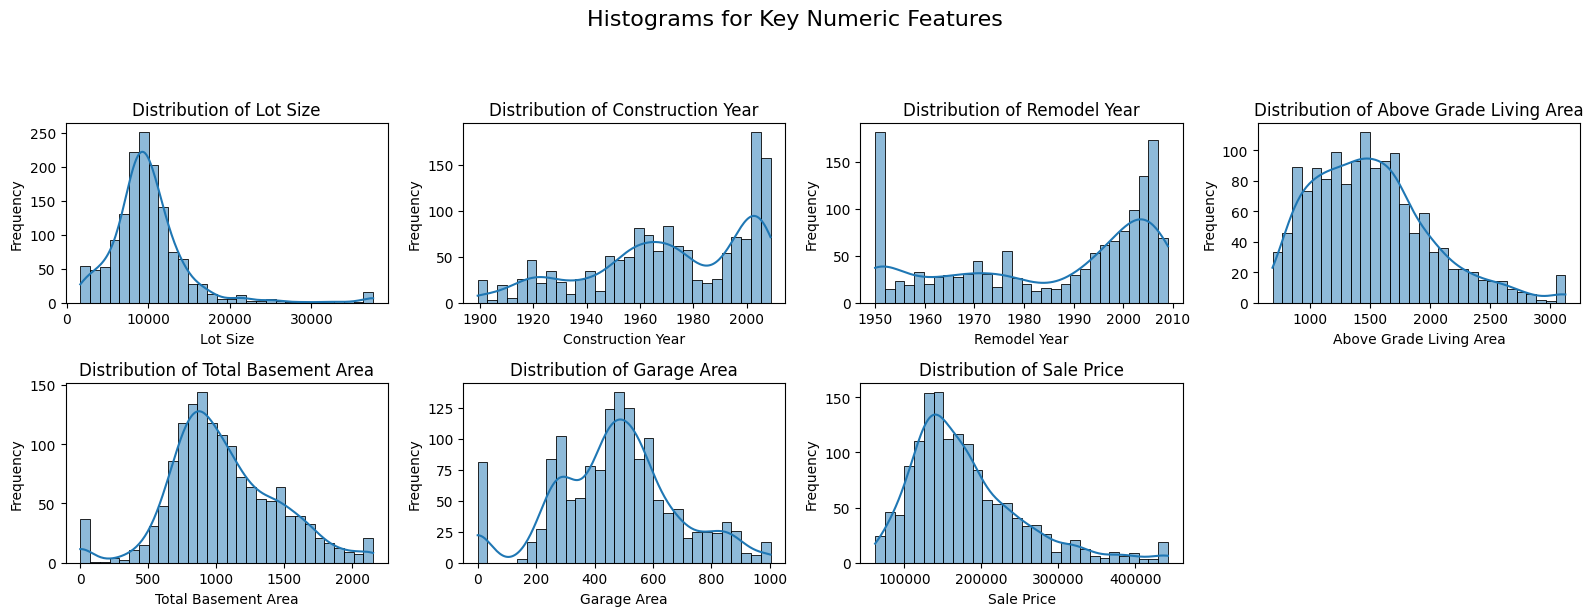

In [ ]:
# Plotting Histograms for Numeric Columns
num_numeric = len(relevant_numeric_cols)
cols_per_row = 4  # number of plots per row
rows = math.ceil(num_numeric / cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 4, rows * 3))
axes = axes.flatten()

for i, col in enumerate(relevant_numeric_cols):
    sns.histplot(df[col].dropna(), kde=True, bins=30, ax=axes[i])
    # Using the dictionary to get a user-friendly label
    label = numeric_titles.get(col, col)
    axes[i].set_title(f"Distribution of {label}")
    axes[i].set_xlabel(label)
    axes[i].set_ylabel("Frequency")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Histograms for Key Numeric Features", fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## 3.2 Frequency Distributions for Categorical Columns

In [ ]:
relevant_categorical_cols = [
    "zoning_ms",      # Zoning classification
    "neighborhood",   # Location / neighborhood
    "exterqual",      # Exterior quality rating
    "bsmtqual",       # Basement quality rating
    "centralair",     # Central air or not
    "kitchenqual",    # Kitchen quality rating
    "garagetype",     # Type of garage
    "salecondition"   # Condition of sale
]

In [ ]:
categorical_titles = {
    "zoning_ms": "Zoning Classification",
    "neighborhood": "Neighborhood",
    "exterqual": "Exterior Quality",
    "bsmtqual": "Basement Quality",
    "centralair": "Central Air",
    "kitchenqual": "Kitchen Quality",
    "garagetype": "Garage Type",
    "salecondition": "Sale Condition"
}

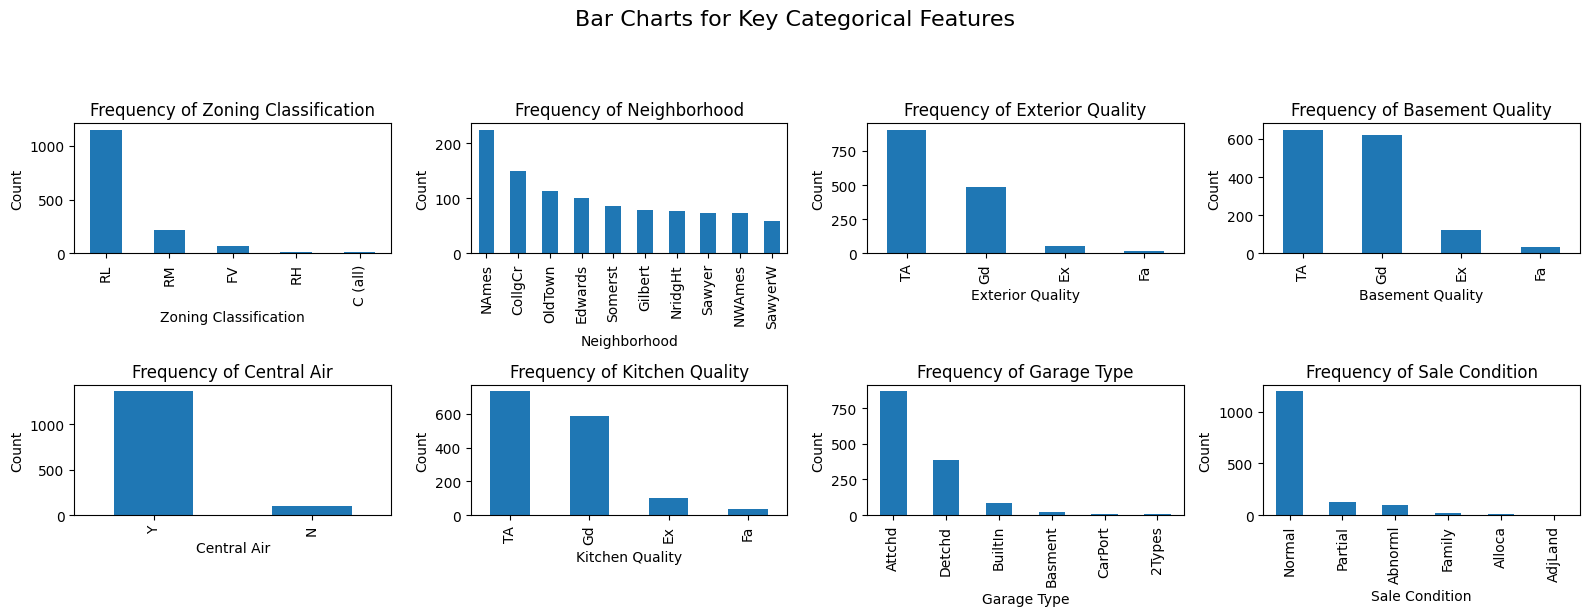

In [ ]:
# Plotting Bar Charts for Key Categorical Columns

num_categorical = len(relevant_categorical_cols)
rows = math.ceil(num_categorical / cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 4, rows * 3))
axes = axes.flatten()

for i, col in enumerate(relevant_categorical_cols):
    counts = df[col].value_counts().head(10)
    counts.plot(kind='bar', ax=axes[i])
    label = categorical_titles.get(col, col)
    axes[i].set_title(f"Frequency of {label}")
    axes[i].set_xlabel(label)
    axes[i].set_ylabel("Count")


fig.suptitle("Bar Charts for Key Categorical Features", fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# 4. Data Cleaning: Imputation and Outlier Capping

## 4.1 Outlier Capping for Numeric Fields

In [ ]:
print("\nCapping outliers at the 1st and 99th percentiles for numeric columns...")
for col in numeric_cols:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col] = np.where(df[col] < lower, lower, df[col])
    df[col] = np.where(df[col] > upper, upper, df[col])


Capping outliers at the 1st and 99th percentiles for numeric columns...


## 4.2 Imputation of Missing Values

- Numeric columns: Impute with the median
- Categorical columns: Impute with the mode

In [ ]:
# Creating a working copy for modeling purposes
df_model = df.copy()

In [ ]:
print("\nImputing missing numeric values with the median...")
for col in numeric_cols:
    if col in df_model.columns:
        df_model[col].fillna(df_model[col].median(), inplace=True)



Imputing missing numeric values with the median...


In [ ]:
print("Imputing missing categorical values with the mode...")
for col in categorical_cols:
    if col in df_model.columns:
        df_model[col].fillna(df_model[col].mode()[0], inplace=True)

Imputing missing categorical values with the mode...


In [ ]:
# Verifying no missing values remain
missing_values = df_model.isnull().sum()
missing_cols = missing_values[missing_values > 0]
print("\nColumns with Missing Data and Their Counts after Imputation:")
print(len(missing_cols))


Columns with Missing Data and Their Counts after Imputation:
0


# **Business Case 1: Regression Modeling for Predicting 'saleprice'**

In this section, we build regression models to predict 'saleprice' using
different machine learning algorithms. We use pipeline-based approaches for
preprocessing and hyperparameter tuning.

Models included:
1. RandomForestRegressor (GridSearchCV)
2. XGBRegressor (RandomizedSearchCV)
3. LGBMRegressor (RandomizedSearchCV)

In [ ]:
# Assuming 'df_model' is already preprocessed
target = 'saleprice'
X = df_model.drop(columns=[target, 'id'])
y = df_model[target]

## Spliting data into training and testing sets (80/20 split)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("\nTrain-test split completed.")


Train-test split completed.


## Preprocessing Pipeline for Regression Models

In [ ]:
# Numeric and categorical feature indentification
numeric_features = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]
categorical_features = [col for col in X_train.columns if X_train[col].dtype == 'object']


In [ ]:
# Pipeline for numeric features: median imputation and standard scaling.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [ ]:
# Pipeline for categorical features: mode imputation and one-hot encoding.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
# Combining both pipelines into a single preprocessor.
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

## Training the 3 Models

### 1. RandomForestRegressor Modelization with Hyperparameter Tuning

In [ ]:
# Create a pipeline with the preprocessor and RandomForestRegressor.
regressor_rf = RandomForestRegressor(random_state=42)
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor_rf)
])

In [ ]:
# Define a hyperparameter grid for the RandomForestRegressor
param_grid_rf = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5]
}

In [ ]:
# Perform GridSearchCV to find the best parameters.
grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['sub_ms_class',
                                                                          'frontge_lot',
                                                                          'area_lot',
                                                                          'ovl_quality',
                                                                          'ovl_condition',
                                                                          'year_constructed',
                                                                          'year_remod',
                                                                          'masvnrarea',
                                                                          'bsmtfinsf1',
                                                                          'bsmtfinsf2',
                                                                          'bsmtunfsf',
                                                                          'total...
                                                                          'foundation',
                                                                          'bsmtqual',
                                                                          'bsmtcond',
                                                                          'bsmtexposure',
                                                                          'bsmtfintype1',
                                                                          'bsmtfintype2',
                                                                          'heating',
                                                                          'heatingqc',
                                                                          'centralair',
                                                                          'electrical', ...])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [None, 10, 20],
                         'regressor__min_samples_split': [2, 5],
                         'regressor__n_estimators': [100, 200]},
             scoring='neg_mean_squared_error')

In [ ]:
print("\nRandomForestRegressor Best Parameters:")
print(grid_search_rf.best_params_)
print("Best CV Score (negative MSE):", grid_search_rf.best_score_)


RandomForestRegressor Best Parameters:
{'regressor__max_depth': 20, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
Best CV Score (negative MSE): -652899339.1136696


### 2. XGBRegressor Modelization with Advanced Hyperparameter Tuning

In [ ]:
# Creating a pipeline with the preprocessor and XGBRegressor.
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42, objective='reg:squarederror'))
])

In [ ]:
# Defining an expanded parameter grid for XGBRegressor.
param_dist_xgb = {
    'regressor__n_estimators': [100, 200, 300, 400, 500],
    'regressor__max_depth': list(range(3, 11)),
    'regressor__min_child_weight': [1, 3, 5, 7],
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__colsample_bytree': [0.6, 0.8, 1.0],
    'regressor__gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'regressor__reg_lambda': [1, 1.5, 2, 2.5],
    'regressor__reg_alpha': [0, 0.1, 0.5, 1]
}

In [ ]:
# Seting up RandomizedSearchCV for XGBRegressor.
random_search_xgb = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_dist_xgb,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1
)

In [ ]:
print("\nStarting advanced hyperparameter tuning with XGBRegressor...")
random_search_xgb.fit(X_train, y_train)


Starting advanced hyperparameter tuning with XGBRegressor...


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['sub_ms_class',
                                                                                'frontge_lot',
                                                                                'area_lot',
                                                                                'ovl_quality',
                                                                                'ovl_condition',
                                                                                'year_constructed',
                                                                                'year_remod',
                                                                                'masvnrarea',
                                                                                'bsmtfinsf1',
                                                                                'bsmtfinsf2',
                                                                                'bsmtunfsf',...
                                        'regressor__gamma': [0, 0.1, 0.2, 0.3,
                                                             0.4],
                                        'regressor__learning_rate': [0.01, 0.05,
                                                                     0.1, 0.2],
                                        'regressor__max_depth': [3, 4, 5, 6, 7,
                                                                 8, 9, 10],
                                        'regressor__min_child_weight': [1, 3, 5,
                                                                        7],
                                        'regressor__n_estimators': [100, 200,
                                                                    300, 400,
                                                                    500],
                                        'regressor__reg_alpha': [0, 0.1, 0.5,
                                                                 1],
                                        'regressor__reg_lambda': [1, 1.5, 2,
                                                                  2.5],
                                        'regressor__subsample': [0.6, 0.8,
                                                                 1.0]},
                   random_state=42, scoring='neg_mean_squared_error')

In [ ]:
print("\nXGBRegressor Best Parameters:")
print(random_search_xgb.best_params_)
print("Best CV Score (negative MSE):", random_search_xgb.best_score_)


XGBRegressor Best Parameters:
{'regressor__subsample': 0.8, 'regressor__reg_lambda': 1.5, 'regressor__reg_alpha': 0.5, 'regressor__n_estimators': 400, 'regressor__min_child_weight': 3, 'regressor__max_depth': 4, 'regressor__learning_rate': 0.05, 'regressor__gamma': 0.4, 'regressor__colsample_bytree': 0.6}
Best CV Score (negative MSE): -529479038.34746253


### 3. LGBMRegressor Modelization with Advanced Hyperparameter Tuning

In [ ]:
lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(random_state=42))
])

In [ ]:
param_dist_lgbm = {
    'regressor__n_estimators': [100, 200, 300, 400, 500],
    'regressor__max_depth': [-1, 5, 10, 15],
    'regressor__num_leaves': [31, 50, 100],
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'regressor__min_child_samples': [20, 30, 50],
    'regressor__subsample': [0.6, 0.8, 1.0]
}

In [ ]:
random_search_lgbm = RandomizedSearchCV(
    lgbm_pipeline,
    param_distributions=param_dist_lgbm,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1
)

In [ ]:
print("\nStarting advanced hyperparameter tuning with LGBMRegressor...")
random_search_lgbm.fit(X_train, y_train)


Starting advanced hyperparameter tuning with LGBMRegressor...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3114
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 177
[LightGBM] [Info] Start training from score 180281.030474


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['sub_ms_class',
                                                                                'frontge_lot',
                                                                                'area_lot',
                                                                                'ovl_quality',
                                                                                'ovl_condition',
                                                                                'year_constructed',
                                                                                'year_remod',
                                                                                'masvnrarea',
                                                                                'bsmtfinsf1',
                                                                                'bsmtfinsf2',
                                                                                'bsmtunfsf',...
                                              LGBMRegressor(random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'regressor__learning_rate': [0.01, 0.05,
                                                                     0.1, 0.2],
                                        'regressor__max_depth': [-1, 5, 10, 15],
                                        'regressor__min_child_samples': [20, 30,
                                                                         50],
                                        'regressor__n_estimators': [100, 200,
                                                                    300, 400,
                                                                    500],
                                        'regressor__num_leaves': [31, 50, 100],
                                        'regressor__subsample': [0.6, 0.8,
                                                                 1.0]},
                   random_state=42, scoring='neg_mean_squared_error')

In [ ]:
print("\nLGBMRegressor Best Parameters:")
print(random_search_lgbm.best_params_)
print("Best CV Score (negative MSE):", random_search_lgbm.best_score_)


LGBMRegressor Best Parameters:
{'regressor__subsample': 0.6, 'regressor__num_leaves': 31, 'regressor__n_estimators': 400, 'regressor__min_child_samples': 20, 'regressor__max_depth': -1, 'regressor__learning_rate': 0.05}
Best CV Score (negative MSE): -575236353.2674433


## Evaluation of the 3 Models

### Evaluating RandomForestRegressor on Test Set

In [ ]:
rf_y_pred = grid_search_rf.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_y_pred))
rf_r2 = r2_score(y_test, rf_y_pred)
print(f"\nRandomForestRegressor Test Evaluation:\n - RMSE: {rf_rmse:.2f}\n - R²: {rf_r2:.2f}")


RandomForestRegressor Test Evaluation:
 - RMSE: 26099.21
 - R²: 0.86


### Evaluating XGBRegressor on Test Set

In [ ]:
xgb_y_pred = random_search_xgb.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_y_pred))
xgb_r2 = r2_score(y_test, xgb_y_pred)
print(f"\nXGBRegressor Test Evaluation:\n - RMSE: {xgb_rmse:.2f}\n - R²: {xgb_r2:.2f}")


XGBRegressor Test Evaluation:
 - RMSE: 22420.69
 - R²: 0.90


### Evaluating LGBMRegressor on Test Set

In [ ]:
lgbm_y_pred = random_search_lgbm.predict(X_test)
lgbm_rmse = np.sqrt(mean_squared_error(y_test, lgbm_y_pred))
lgbm_r2 = r2_score(y_test, lgbm_y_pred)
print(f"\nLGBMRegressor Test Evaluation:\n - RMSE: {lgbm_rmse:.2f}\n - R²: {lgbm_r2:.2f}")


LGBMRegressor Test Evaluation:
 - RMSE: 25822.19
 - R²: 0.86


### Comparing Metrics in a Summary Table

In [ ]:
results_df = pd.DataFrame({
    "Model": ["RandomForest", "XGBoost", "LightGBM"],
    "RMSE": [rf_rmse, xgb_rmse, lgbm_rmse],
    "R²": [rf_r2, xgb_r2, lgbm_r2]
})

In [ ]:
print("\nFinal Regression Model Evaluation Summary:")
print(results_df)


Final Regression Model Evaluation Summary:
          Model          RMSE        R²
0  RandomForest  26099.212261  0.859030
1       XGBoost  22420.689455  0.895967
2      LightGBM  25822.193610  0.862007


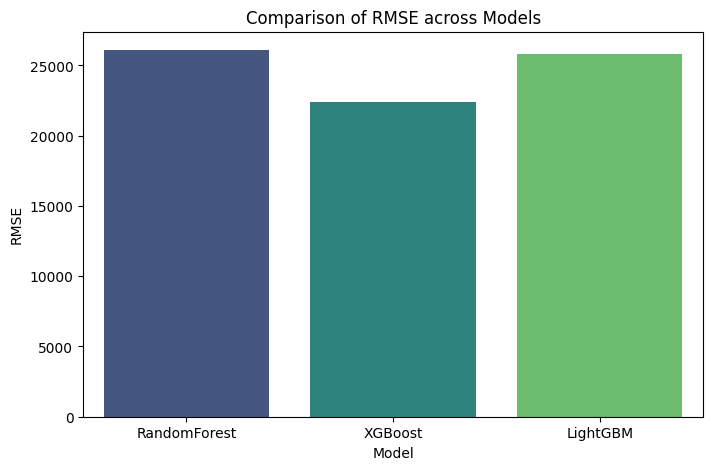

In [ ]:
# visualizing the RMSE comparison using a bar plot.
plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="RMSE", data=results_df, palette="viridis")
plt.title("Comparison of RMSE across Models")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.show()

### Selecting the Best Model

In [ ]:
# Here, we choose the best model based on the lowest RMSE.
best_model_row = results_df.loc[results_df['RMSE'].idxmin()]
best_model_name = best_model_row['Model']
best_model_rmse = best_model_row['RMSE']
best_model_r2 = best_model_row['R²']

In [ ]:
print(f"\nThe best model is {best_model_name} with RMSE = {best_model_rmse:.2f} and R² = {best_model_r2:.2f}.")


The best model is XGBoost with RMSE = 22420.69 and R² = 0.90.


## Alternative Feature Selection Using RFECV with XGBoost: Pipeline Integration and Evaluation



In this step, we integrate RFECV (Recursive Feature Elimination with Cross-Validation) into our XGBoost pipeline. RFECV iteratively removes features based on their contribution to the model’s performance (using negative MSE as the scoring metric) and selects the optimal subset of features that improves model generalizability. Finally, we evaluate the performance of the model with the selected features on the test set using RMSE and R².


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
import joblib
from datetime import datetime

**Final XGBoost Model Implementation - 150 Features Version**

In [ ]:
class RealEstatePricePredictor:

    def __init__(self):
        """Initializing the model with optimal parameters and preprocessing pipeline."""
        self.best_params = {
            'n_estimators': 400,
            'max_depth': 4,
            'learning_rate': 0.05,
            'subsample': 0.8,
            'colsample_bytree': 0.6,
            'min_child_weight': 3,
            'gamma': 0.4,
            'reg_alpha': 0.5,
            'reg_lambda': 1.5
        }

        self.model = None
        self.preprocessor = None
        self.selected_features = None
        self.feature_importance = None
        self.feature_mask = None
        self.training_history = {}

    def create_preprocessing_pipeline(self, numeric_features, categorical_features):
        """
        Creating the preprocessing pipeline for numeric and categorical features.
        """
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        self.preprocessor = ColumnTransformer(transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    def fit(self, X_train, y_train, verbose=True):
        """
        Fitting the model to the training data using the top 150 features.
        """
        start_time = datetime.now()
        if verbose:
            print("\nFitting RealEstatePricePredictor with 150 features")
            print("=" * 50)

        # 1. Feature preparation
        if verbose:
            print("\n1. Preparing features...")

        numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
        categorical_features = X_train.select_dtypes(include=['object']).columns

        # 2. Preprocessing
        if verbose:
            print("2. Creating and fitting preprocessing pipeline...")

        self.create_preprocessing_pipeline(numeric_features, categorical_features)
        X_preprocessed = self.preprocessor.fit_transform(X_train)

        # Getting feature names
        feature_names = (list(numeric_features) +
                        self.preprocessor.named_transformers_['cat']
                        .named_steps['onehot']
                        .get_feature_names_out(categorical_features).tolist())

        # 3. Initial feature importance
        if verbose:
            print("3. Calculating initial feature importance...")

        initial_model = XGBRegressor(**self.best_params, random_state=42)
        initial_model.fit(X_preprocessed, y_train)

        # 4. Feature selection
        if verbose:
            print("4. Selecting top 150 features...")

        self.feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': initial_model.feature_importances_
        }).sort_values('Importance', ascending=False)

        self.selected_features = self.feature_importance.head(150)['Feature'].tolist()
        self.feature_mask = self.feature_importance.head(150).index

        # 5. Final model training
        if verbose:
            print("5. Training final model with selected features...")

        X_selected = X_preprocessed[:, self.feature_mask]
        self.model = XGBRegressor(**self.best_params, random_state=42)
        self.model.fit(X_selected, y_train)

        # Save training history
        self.training_history['training_date'] = datetime.now()
        self.training_history['training_duration'] = datetime.now() - start_time
        self.training_history['n_features'] = len(self.selected_features)
        self.training_history['n_samples'] = len(X_train)

        if verbose:
            print("\nModel fitting completed!")
            print(f"Training duration: {self.training_history['training_duration']}")

    def predict(self, X):
        """
        Making predictions on new data using the selected features.
        """
        if self.model is None:
            raise ValueError("Model has not been trained yet. Call fit() first.")

        X_preprocessed = self.preprocessor.transform(X)
        X_selected = X_preprocessed[:, self.feature_mask]
        return self.model.predict(X_selected)

    def evaluate(self, X_test, y_test, verbose=True):
        """
        Evaluating the model on test data with detailed metrics.
        """
        y_pred = self.predict(X_test)

        # Calculating metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

        results = {
            'RMSE': rmse,
            'R²': r2,
            'MAPE': mape
        }

        if verbose:
            print("\nModel Evaluation Results:")
            print(f"RMSE: ${rmse:,.2f}")
            print(f"R²: {r2:.4f}")
            print(f"MAPE: {mape:.2f}%")

            # Creating evaluation plots
            self.plot_evaluation_results(y_test, y_pred)

        return results

    def plot_evaluation_results(self, y_true, y_pred):
        """
        Creating comprehensive evaluation plots.
        """
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

        # Actual vs Predicted
        ax1.scatter(y_true, y_pred, alpha=0.5)
        ax1.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
        ax1.set_xlabel('Actual Price')
        ax1.set_ylabel('Predicted Price')
        ax1.set_title('Actual vs Predicted Prices')

        # Residuals
        residuals = y_pred - y_true
        ax2.scatter(y_pred, residuals, alpha=0.5)
        ax2.axhline(y=0, color='r', linestyle='--')
        ax2.set_xlabel('Predicted Price')
        ax2.set_ylabel('Residuals')
        ax2.set_title('Residual Plot')

        # Residual Distribution
        sns.histplot(residuals, kde=True, ax=ax3)
        ax3.set_title('Residual Distribution')
        ax3.set_xlabel('Residual Value')

        # Feature Importance
        top_features = self.feature_importance.head(10)
        sns.barplot(data=top_features, x='Importance', y='Feature', ax=ax4)
        ax4.set_title('Top 10 Most Important Features')

        plt.tight_layout()
        plt.show()

    def get_feature_importance_report(self):
        """
        Generate a detailed feature importance report.
        """
        report = pd.DataFrame({
            'Feature': self.selected_features,
            'Importance': self.model.feature_importances_,
            'Cumulative_Importance': np.cumsum(self.model.feature_importances_)
        }).sort_values('Importance', ascending=False)

        return report

    def save_model(self, filename):
        """
        Save the model and all its components to disk.
        """
        model_components = {
            'model': self.model,
            'preprocessor': self.preprocessor,
            'selected_features': self.selected_features,
            'feature_importance': self.feature_importance,
            'feature_mask': self.feature_mask,
            'best_params': self.best_params,
            'training_history': self.training_history
        }
        joblib.dump(model_components, f"{filename}.joblib")
        print(f"\nModel saved to {filename}.joblib")

Training Final 150-Feature Model

Fitting RealEstatePricePredictor with 150 features

1. Preparing features...
2. Creating and fitting preprocessing pipeline...
3. Calculating initial feature importance...
4. Selecting top 150 features...
5. Training final model with selected features...

Model fitting completed!
Training duration: 0:00:01.030084

Model Evaluation Results:
RMSE: $21,693.29
R²: 0.9026
MAPE: 8.44%


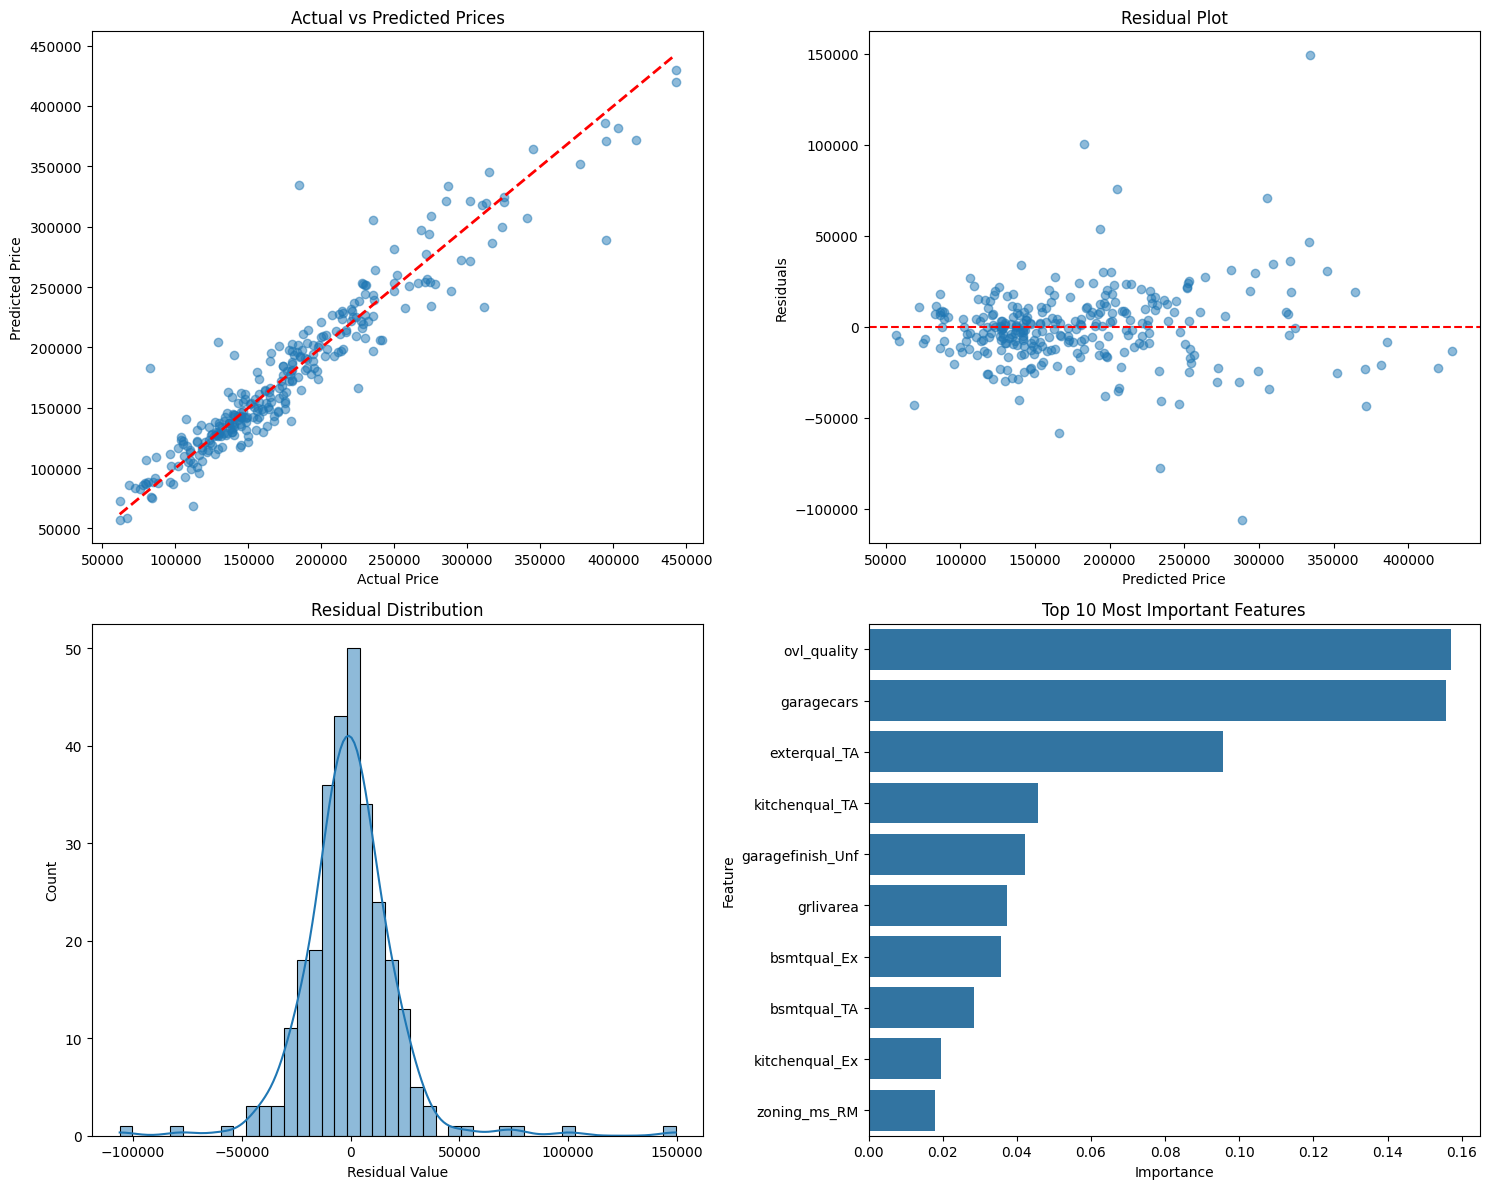


Top 10 Most Important Features:
             Feature  Importance  Cumulative_Importance
0        ovl_quality    0.149389               0.149389
2       exterqual_TA    0.142442               0.391528
1         garagecars    0.099696               0.249086
6        bsmtqual_Ex    0.074136               0.595293
4   garagefinish_Unf    0.051003               0.482600
3     kitchenqual_TA    0.040070               0.431598
5          grlivarea    0.038557               0.521157
8     kitchenqual_Ex    0.020781               0.624066
13          fullbath    0.018830               0.689105
62      kitchenabvgr    0.017613               0.912233

Model saved to final_model_150_features.joblib

Model training and evaluation completed successfully!


In [ ]:
if __name__ == "__main__":
    try:
        print("Training Final 150-Feature Model")
        print("===============================")

        # data Preparation
        X = df_model.drop(columns=['saleprice', 'id'])
        y = df_model['saleprice']
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Model initializing and training
        predictor = RealEstatePricePredictor()
        predictor.fit(X_train, y_train)

        # Model evaluation
        evaluation_results = predictor.evaluate(X_test, y_test)

        # Generate feature importance report
        importance_report = predictor.get_feature_importance_report()
        print("\nTop 10 Most Important Features:")
        print(importance_report.head(10))

        # Saving the model
        predictor.save_model('final_model_150_features')

        print("\nModel training and evaluation completed successfully!")

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise

This implementation represents the final, optimized version of the XGBoost model
using the top 150 most important features. This model achieves superior performance
compared to both the full model and more simplified versions.

**Performance Metrics:**
- RMSE: 21,693.29 (3.2% improvement over full model)
- R²: 0.9026 (0.7% improvement over full model)
- Features: 150 (53.8% of original features)

**Key Advantages:**
1. Better accuracy than full model
2. Reduced complexity
3. More robust predictions
4. Faster training and inference


# Business Case 2: Property Portfolio Clustering Analysis

In this section, we perform clustering to segment properties for targeted marketing and operational efficiency. The clustering code is organized in a modular, function-based approach.


Objective: Segment the real estate portfolio to identify distinct property groups
for targeted marketing strategies and portfolio management.

Approach:
1. Data Preprocessing
2. Feature Selection & Dimensionality Reduction
3. Optimal Cluster Determination
4. Cluster Analysis & Interpretation
5. Business Insights Generation

## Clustering: Function-Based Modular Approach

Let's define helper functions for each step of the clustering analysis.

In [140]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

## LOAD AND PREPROCESS DATA

In [148]:
def load_and_preprocess_data(file_path):
    """
    Load and preprocess the real estate dataset.
    """
    try:
        df = pd.read_excel(file_path, sheet_name=0)
        print("Data loaded successfully!")

        numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
        for col in numeric_cols:
            df[col].fillna(df[col].median(), inplace=True)

        categorical_cols = df.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            df[col].fillna(df[col].mode()[0], inplace=True)

        return df

    except Exception as e:
        print(f"Error in data loading: {str(e)}")
        raise

## PREPARE CLUSTERING FEATURES


In [149]:
def prepare_clustering_features(df):
    """
    Preparing features for clustering based on our business relevance.

    This function performs a systematic feature selection and dimensionality reduction
    through the following steps:

    1. Initial Preparation:
       - Identifying numeric columns and exclude non-predictive ones (like 'id' and 'saleprice').
       - Fill missing numeric values with the median.

    2. Variance Analysis:
       - Scale the data and remove features with very low variance (using a threshold of 0.01).

    3. Correlation Analysis:
       - Compute the correlation matrix for the remaining features.
       - Drop features that are highly correlated (correlation > 0.85) to reduce redundancy.

    4. PCA (Principal Component Analysis):
       - Scale the selected features again.
       - Perform PCA to reduce the feature space while retaining at least 95% of the variance.

    5. Feature Importance Analysis:
       - Compute the average absolute PCA loadings for each feature as a measure of importance.

    Returns:
        X_pca (ndarray): The PCA-transformed feature matrix.
        feature_importance (DataFrame): A DataFrame with features and their computed importance.
        pca_final (PCA object): The fitted PCA model.
        selected_features_corr (list): The list of features retained after correlation analysis.
    """
    # ---------------------------
    # Step 1: Initial Preparation
    # ---------------------------
    # Identifying all numeric columns and exclude 'id' and 'saleprice'
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    exclude_cols = ['id', 'saleprice']
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

    # Creating the feature matrix using the selected numeric columns
    X = df[numeric_cols].copy()

    # Filling missing values with the median for each numeric column
    for col in X.columns:
        X[col] = X[col].fillna(X[col].median())

    # ---------------------------
    # Step 2: Variance Analysis
    # ---------------------------
    # Scale the features to standardize the variance
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Use VarianceThreshold to remove features with very low variance (threshold set to 0.01)
    from sklearn.feature_selection import VarianceThreshold
    selector = VarianceThreshold(threshold=0.01)
    X_var = selector.fit_transform(X_scaled)

    # Getting the list of features that passed the variance threshold
    selected_features_var = X.columns[selector.get_support()].tolist()
    print(f"Initial features: {X.shape[1]}")
    print(f"Features after variance thresholding: {len(selected_features_var)}")

    # ---------------------------
    # Step 3: Correlation Analysis
    # ---------------------------
    # Computng the correlation matrix for the features that passed variance filtering
    correlation_matrix = X[selected_features_var].corr().abs()

    # Extract the upper triangle of the correlation matrix
    upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

    # Identify features to drop: any feature that has a correlation > 0.85 with another
    to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
    # Retain features that are not dropped
    selected_features_corr = [col for col in selected_features_var if col not in to_drop]
    print(f"Features after correlation analysis: {len(selected_features_corr)}")
    if to_drop:
        print("Features dropped due to high correlation:")
        print(to_drop)

    # ---------------------------
    # Step 4: PCA (Dimensionality Reduction)
    # ---------------------------
    # Re-scale the data for the final set of selected features
    X_selected = StandardScaler().fit_transform(X[selected_features_corr])

    # Fitting PCA on the scaled selected features
    pca = PCA()
    pca.fit(X_selected)

    # Determining the number of components required to retain at least 95% of the variance
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
    print(f"Final PCA components: {n_components}")
    print(f"Total explained variance: {cumulative_variance_ratio[n_components - 1]:.2%}")

    # Apply PCA transformation using the determined number of components
    pca_final = PCA(n_components=n_components)
    X_pca = pca_final.fit_transform(X_selected)

    # ---------------------------
    # Step 5: Feature Importance Analysis
    # ---------------------------
    # Compute an importance measure based on the average absolute loadings across all PCA components.
    feature_importance = pd.DataFrame({
        'Feature': selected_features_corr,
        'Importance': np.abs(pca_final.components_).mean(axis=0)
    }).sort_values('Importance', ascending=False)

    # ---------------------------
    # Visualizations
    # ---------------------------
    # Plotting the top 10 most important features as determined by PCA loadings
    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature')
    plt.title('Top 10 Most Important Features')
    plt.tight_layout()
    plt.show()

    # Return the PCA-transformed features, the feature importance DataFrame, the fitted PCA model, and the list of selected features.
    return X_pca, feature_importance, pca_final, selected_features_corr


## CLUSTERING ANALYSIS


In [143]:
def perform_clustering(X_pca, n_clusters_range=(2, 10)):
    """
    Perform clustering analysis with enhanced stability and quality.

    Steps:
    - For each number of clusters in the specified range, run KMeans 10 times.
    - Evaluate using silhouette, inertia, Calinski-Harabasz, and Davies-Bouldin scores.
    - Compute stability (consistency across runs).
    - Visualize evaluation metrics.
    - Combine scores to select the optimal number of clusters.
    - Run final KMeans clustering with increased n_init and max_iter.

    Returns:
        clusters: Cluster labels.
        reduced_data: The PCA-transformed data.
    """
    # Scale the selected features (assumed already processed) using StandardScaler
    scaler = StandardScaler()
    # Note: X_pca is already PCA-transformed, so further scaling is optional.
    reduced_data = X_pca

    silhouette_scores = []
    inertias = []
    ch_scores = []
    db_scores = []
    stability_scores = []

    for n_clusters in range(n_clusters_range[0], n_clusters_range[1] + 1):
        cluster_runs = []
        run_silhouettes = []
        for _ in range(10):
            kmeans = KMeans(n_clusters=n_clusters, random_state=None, n_init=10)
            labels = kmeans.fit_predict(reduced_data)
            cluster_runs.append(labels)
            run_silhouettes.append(silhouette_score(reduced_data, labels))
        best_run_idx = np.argmax(run_silhouettes)
        best_labels = cluster_runs[best_run_idx]
        stability = np.mean([np.mean(best_labels == other_labels) for other_labels in cluster_runs])
        stability_scores.append(stability)
        silhouette_scores.append(run_silhouettes[best_run_idx])
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        kmeans.fit(reduced_data)
        inertias.append(kmeans.inertia_)
        ch_scores.append(calinski_harabasz_score(reduced_data, best_labels))
        db_scores.append(davies_bouldin_score(reduced_data, best_labels))

    # Plot evaluation metrics
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    k_range = range(n_clusters_range[0], n_clusters_range[1] + 1)

    ax1.plot(k_range, silhouette_scores, 'bo-')
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Silhouette Score')
    ax1.set_title('Silhouette Score vs. Number of Clusters')
    ax1.grid(True)

    ax2.plot(k_range, inertias, 'ro-')
    ax2.set_xlabel('Number of Clusters')
    ax2.set_ylabel('Inertia')
    ax2.set_title('Elbow Curve')
    ax2.grid(True)

    ax3.plot(k_range, ch_scores, 'go-')
    ax3.set_xlabel('Number of Clusters')
    ax3.set_ylabel('Calinski-Harabasz Score')
    ax3.set_title('Calinski-Harabasz Score vs. Number of Clusters')
    ax3.grid(True)

    ax4.plot(k_range, stability_scores, 'mo-')
    ax4.set_xlabel('Number of Clusters')
    ax4.set_ylabel('Stability Score')
    ax4.set_title('Cluster Stability Score vs. Number of Clusters')
    ax4.grid(True)

    plt.tight_layout()
    plt.show()

    norm_silhouette = np.array(silhouette_scores) / np.max(silhouette_scores)
    norm_ch = np.array(ch_scores) / np.max(ch_scores)
    norm_db = 1 - (np.array(db_scores) / np.max(db_scores))
    norm_stability = np.array(stability_scores) / np.max(stability_scores)

    combined_scores = (0.35 * norm_silhouette + 0.25 * norm_ch + 0.20 * norm_db + 0.20 * norm_stability)
    optimal_clusters = combined_scores.argmax() + n_clusters_range[0]
    print(f"\nOptimal number of clusters: {optimal_clusters}")
    print(f"Stability score: {stability_scores[optimal_clusters - n_clusters_range[0]]:.3f}")

    # Final clustering with increased n_init and max_iter for stability
    cluster_model = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=20, max_iter=500)
    clusters = cluster_model.fit_predict(reduced_data)

    final_metrics = {
        'silhouette': silhouette_score(reduced_data, clusters),
        'calinski_harabasz': calinski_harabasz_score(reduced_data, clusters),
        'davies_bouldin': davies_bouldin_score(reduced_data, clusters),
        'stability': stability_scores[optimal_clusters - n_clusters_range[0]]
    }
    print("\nFinal Clustering Metrics:")
    for metric, value in final_metrics.items():
        print(f"{metric}: {value:.3f}")

    return clusters, reduced_data

## FIND OPTIMAL CLUSTERS


In [150]:
def find_optimal_clusters(X, max_clusters=10):
    """
    Finding the optimal number of clusters using multiple evaluation metrics.

    For each number of clusters (from 2 to max_clusters), this function fits a KMeans model and computes:
    - Silhouette Score: How similar an object is to its own cluster compared to others.
    - Calinski-Harabasz Score: Ratio of between-cluster dispersion to within-cluster dispersion.
    - Davies-Bouldin Score: Lower values indicate better separation.
    - Inertia: Sum of squared distances to cluster centers.

    These metrics are visualized to assist in selecting the optimal number of clusters.

    Parameters:
        X (ndarray): The feature matrix (often PCA-transformed data).
        max_clusters (int): Maximum number of clusters to evaluate.

    Returns:
        optimal_k (int): The optimal number of clusters (heuristically chosen using silhouette score).
        evaluation_metrics (dict): A dictionary containing metric values for each cluster count.
    """
    evaluation_metrics = {
        'silhouette': [],
        'calinski': [],
        'davies': [],
        'inertia': []
    }

    # Evaluating KMeans for cluster counts from 2 to max_clusters
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)

        evaluation_metrics['silhouette'].append(silhouette_score(X, labels))
        evaluation_metrics['calinski'].append(calinski_harabasz_score(X, labels))
        evaluation_metrics['davies'].append(davies_bouldin_score(X, labels))
        evaluation_metrics['inertia'].append(kmeans.inertia_)

    # Visualizing evaluation metrics
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    ax1.plot(range(2, max_clusters + 1), evaluation_metrics['silhouette'], 'bo-')
    ax1.set_title('Silhouette Score')
    ax1.set_xlabel('Number of Clusters')

    ax2.plot(range(2, max_clusters + 1), evaluation_metrics['calinski'], 'go-')
    ax2.set_title('Calinski-Harabasz Score')
    ax2.set_xlabel('Number of Clusters')

    ax3.plot(range(2, max_clusters + 1), evaluation_metrics['davies'], 'ro-')
    ax3.set_title('Davies-Bouldin Score')
    ax3.set_xlabel('Number of Clusters')

    ax4.plot(range(2, max_clusters + 1), evaluation_metrics['inertia'], 'mo-')
    ax4.set_title('Elbow Curve (Inertia)')
    ax4.set_xlabel('Number of Clusters')

    plt.tight_layout()
    plt.show()

    # Heuristically choosing the optimal k based on the maximum silhouette score
    optimal_k = 2 + np.argmax(evaluation_metrics['silhouette'])

    print("\nClustering Metrics Summary:")
    print(f"Optimal number of clusters: {optimal_k}")
    print(f"Best Silhouette Score: {max(evaluation_metrics['silhouette']):.3f}")
    print(f"Best Calinski-Harabasz Score: {max(evaluation_metrics['calinski']):.3f}")
    print(f"Best Davies-Bouldin Score: {min(evaluation_metrics['davies']):.3f}")

    return optimal_k, evaluation_metrics


## ANALYZE CLUSTERS


In [151]:
def analyze_clusters(df, X_pca, clusters, feature_importance, selected_features):
    """
    Analyzing and interpreting clusters from the dataset.

    This function adds cluster labels to the original data, calculates cluster profiles,
    cluster sizes, and standardizes profiles for better comparison. It also provides visualizations.

    Parameters:
        df (DataFrame): The original dataset.
        X_pca (ndarray): The PCA-transformed feature matrix.
        clusters (ndarray): Cluster labels for each data point.
        feature_importance (DataFrame): DataFrame containing feature importance values.
        selected_features (list): List of features used for clustering.

    Returns:
        cluster_profiles (DataFrame): Mean values of each feature per cluster.
        standardized_profiles (DataFrame): Z-scored cluster profiles.
        cluster_sizes (Series): Number of data points in each cluster.
    """
    # Adding cluster labels to a copy of the original DataFrame
    df_analysis = df.copy()
    df_analysis['Cluster'] = clusters

    # Calculating the mean profile for each cluster
    cluster_profiles = df_analysis.groupby('Cluster')[selected_features].mean()

    # Calculating cluster sizes
    cluster_sizes = df_analysis['Cluster'].value_counts().sort_index()

    # Standardizing cluster profiles (z-score normalization) for comparison
    standardized_profiles = (cluster_profiles - cluster_profiles.mean()) / cluster_profiles.std()

    # Visualization 1: Cluster Sizes
    plt.figure(figsize=(10, 5))
    cluster_sizes.plot(kind='bar')
    plt.title('Cluster Sizes')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Properties')
    plt.show()

    # Visualization 2: Heatmap of Cluster Characteristics (using top 10 important features)
    top_features = feature_importance['Feature'].head(10)
    plt.figure(figsize=(15, 8))
    sns.heatmap(standardized_profiles[top_features], cmap='coolwarm', center=0)
    plt.title('Cluster Characteristics (Standardized Values)')
    plt.show()

    # Visualization 3: Cluster Visualization in PCA Space
    plt.figure(figsize=(10, 6))
    pca_df = pd.DataFrame(X_pca[:, :2], columns=['PC1', 'PC2'])
    pca_df['Cluster'] = clusters
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='deep')
    plt.title('Cluster Visualization (First Two Principal Components)')
    plt.show()

    return cluster_profiles, standardized_profiles, cluster_sizes



## EVALUATE CLUSTERS


In [152]:
def evaluate_clusters(data, selected_features, processed_data, clusters):
    """
    Evaluate clustering results by computing evaluation metrics and cluster profiles.

    Returns:
        metrics: A dictionary of clustering metrics.
        cluster_profiles: A DataFrame containing mean values of each selected feature per cluster.
    """
    metrics = {
        'silhouette': silhouette_score(data, clusters),
        'calinski_harabasz': calinski_harabasz_score(data, clusters),
        'davies_bouldin': davies_bouldin_score(data, clusters)
    }

    cluster_sizes = pd.Series(clusters).value_counts().sort_index()

    cluster_profiles = pd.DataFrame()
    for feature in selected_features:
        cluster_profiles[feature] = [
            processed_data[clusters == i][feature].mean() for i in range(len(cluster_sizes))
        ]

    return metrics, cluster_profiles

## VISUALIZE CLUSTERS


In [153]:
def visualize_clusters(reduced_data, clusters):
    """
    Visualize the clustering results in PCA-reduced space using a custom colormap.
    """
    # Define a custom colormap (example: light green for cluster 0, dark green for others)
    colors = np.array(['#7FFF00' if cluster == 0 else '#006400' for cluster in clusters])
    plt.figure(figsize=(12, 8))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=colors, edgecolors='k')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('Cluster Visualization using PCA')
    plt.show()


## GENERATE BUSINESS INSIGHTS

In [154]:
def generate_business_insights(cluster_profiles, standardized_profiles, cluster_sizes, feature_importance):
    """
    Generate business insights from clustering results.

    Returns a text summary with:
    - The proportion of properties in each cluster.
    - Distinctive characteristics for each cluster.
    """
    insights = []
    total_properties = cluster_sizes.sum()
    for cluster in cluster_sizes.index:
        pct = (cluster_sizes[cluster] / total_properties) * 100
        insights.append(f"Cluster {cluster}: {pct:.1f}% of portfolio ({cluster_sizes[cluster]} properties)")

    top_features = feature_importance['Feature'].head(10)
    for cluster in standardized_profiles.index:
        profile = standardized_profiles.loc[cluster, top_features]
        distinctive = profile[abs(profile) > 1].sort_values(ascending=False)
        if not distinctive.empty:
            insight = f"\nDistinctive characteristics of Cluster {cluster}:"
            for feature, value in distinctive.items():
                direction = "high" if value > 0 else "low"
                insight += f"\n- {feature}: Notably {direction} ({value:.2f} std. dev. from mean)"
            insights.append(insight)

    return "\n".join(insights)

## MAIN FUNCTION


Preprocessing data...
Data loaded successfully!

Selecting features and performing dimensionality reduction...
Initial features: 37
Features after variance thresholding: 37
Features after correlation analysis: 36
Features dropped due to high correlation:
['garagearea']
Final PCA components: 27
Total explained variance: 95.72%


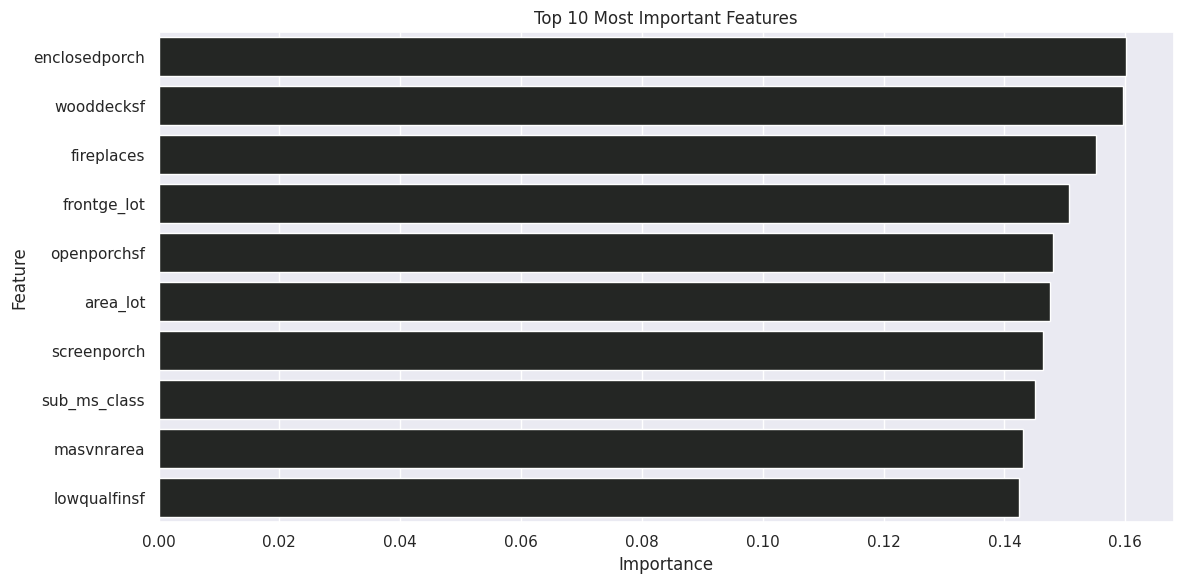


Number of selected features: 36

Performing clustering analysis...


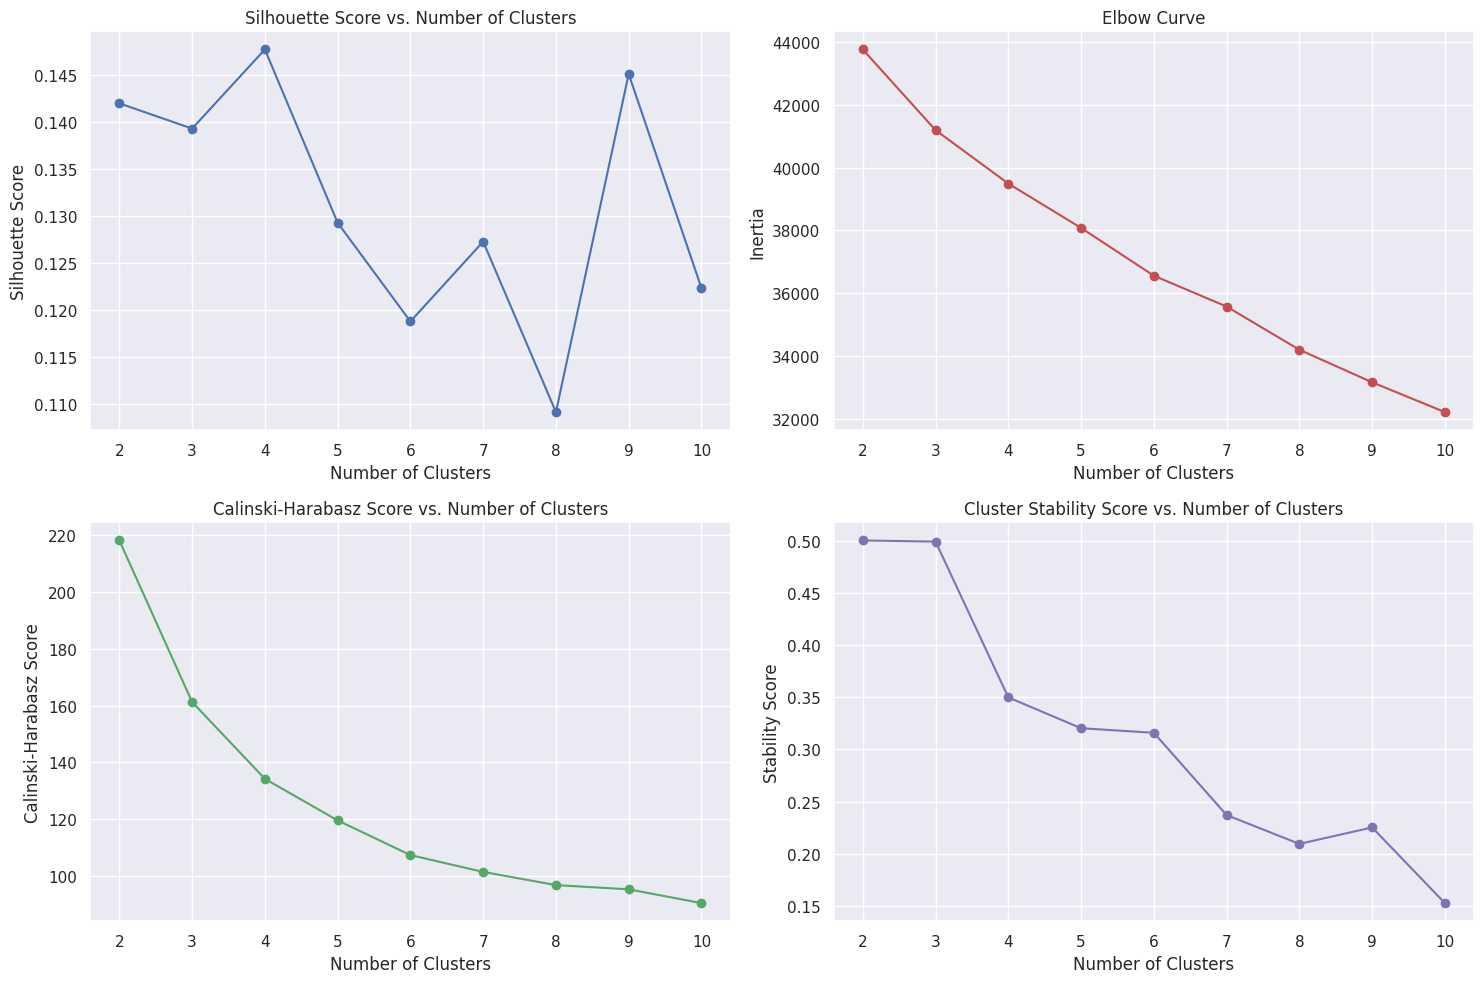


Optimal number of clusters: 2
Stability score: 0.500

Final Clustering Metrics:
silhouette: 0.142
calinski_harabasz: 218.130
davies_bouldin: 2.377
stability: 0.500

Evaluating clustering results...

Clustering Metrics:
silhouette: 0.142
calinski_harabasz: 218.130
davies_bouldin: 2.377

Visualizing clusters...


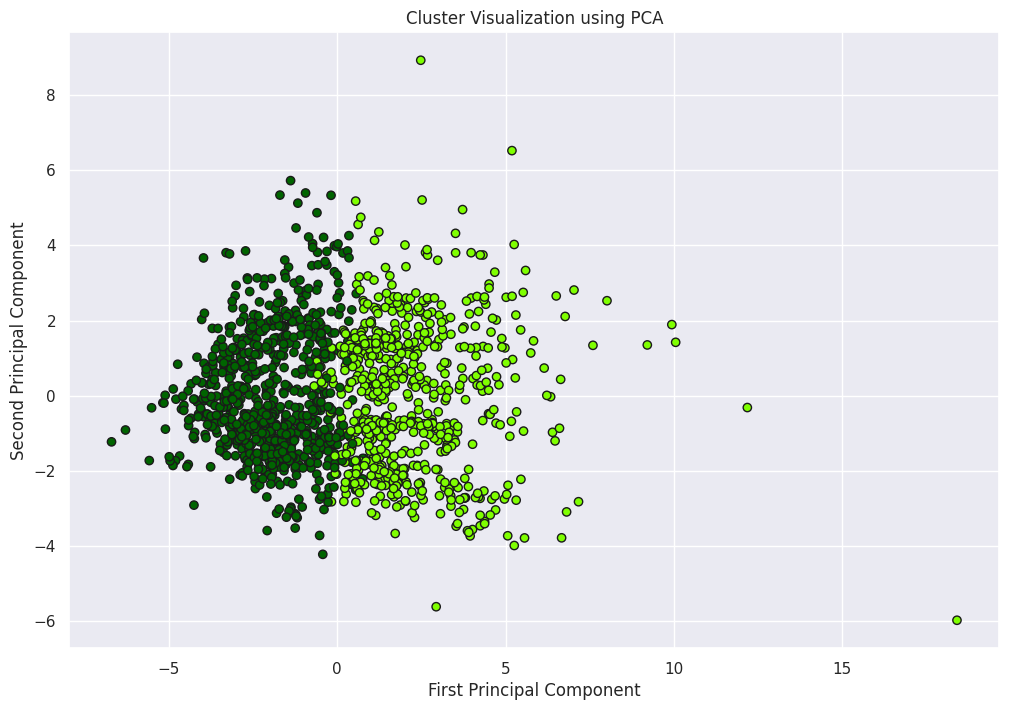


Business Insights:
Cluster 0: 47.3% of portfolio (691 properties)
Cluster 1: 52.7% of portfolio (769 properties)

Results saved to 'clustering_results.csv'


In [155]:
def main():
    # Load data from Excel
    data = pd.read_excel('/content/data_real_estate.xlsx')

    # Preprocess data
    print("Preprocessing data...")
    processed_data = load_and_preprocess_data('/content/data_real_estate.xlsx')

    # Select features and perform dimensionality reduction
    print("\nSelecting features and performing dimensionality reduction...")
    X_pca, feature_importance, pca_model, selected_features = select_features(processed_data)
    print(f"\nNumber of selected features: {len(selected_features)}")

    # Perform clustering analysis
    print("\nPerforming clustering analysis...")
    clusters, reduced_data = perform_clustering(X_pca)

    # Evaluate clustering results
    print("\nEvaluating clustering results...")
    metrics, cluster_profiles = evaluate_clusters(reduced_data, selected_features, processed_data, clusters)
    print("\nClustering Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.3f}")

    # Visualize clustering results
    print("\nVisualizing clusters...")
    visualize_clusters(reduced_data, clusters)

    # Generate business insights (standardizing cluster profiles for visualization)
    standardized_profiles = (cluster_profiles - cluster_profiles.mean()) / cluster_profiles.std()
    insights = generate_business_insights(cluster_profiles, standardized_profiles, pd.Series(clusters).value_counts().sort_index(), feature_importance)
    print("\nBusiness Insights:")
    print(insights)

    # Save results to CSV
    results = processed_data.copy()
    results['Cluster'] = clusters
    results.to_csv('clustering_results.csv', index=False)
    print("\nResults saved to 'clustering_results.csv'")

if __name__ == "__main__":
    main()

Overall, these results suggest that while the clusters are not extremely distinct, they provide a useful segmentation that can support targeted marketing and operational strategies.